# Quantitative Asset Allocation - Davide Valzelli

Objective: Develop a strategic asset allocation plan for an investor seeking a balanced portfolio comprising 50% equity and 50% bonds. The asset allocation strategy will encompass various asset classes, including Equity Europe, Equity North America, Equity Pacific, Equity Emerging Markets, Bond Europe (Short, Mid, and Long term), High Yield Corporate Bond Global, and Global Bond Corporate. The chosen proxy for each asset class is detailed in the table below:


\begin{align}
&\begin{array}{cc}
\hline \text { Asset Class } & \text { Index }\\
\hline
\text{Bond Europe (Short term)} & \text{FTSE Europe Government 1-3Y Bond Index}\\
\text{Bond Europe (Mid term)} & \text{FTSE Europe Government 5-7Y Bond Index}\\
\text{Bond Europe (Long term)} & \text{FTSE Europe Government 10+Y Bond Index}\\
\text{Global Bond Corporate} & \text{Bloomberg Global Agg Corporate Total Return Index}\\
\text{High Yield Corporate Bond} & \text{Bloomberg Global High Yield Total Return Index}\\
\text{Equity Europe} & \text{MSCI Europe}\\
\text{Equity Nord America} & \text{MSCI North America} \\
\text{Equity Pacific} & \text{MSCI Pacific}\\
\text{Equity Emerging Markets} & \text{MSCI Emerging Markets}\\
\hline
\end{array}
\end{align}

To establish market-neutral weights for each asset class, I calculate these weights based on their market capitalizations. The market capitalization for each index is estimated using the iShares ETF that corresponds to the respective asset class. The table below outlines the asset classes along with their indices, iShares ETF proxies, market capitalizations, and market-neutral weights within the class:

| Asset Class | Index | iShares ETF |Market Cap. (in B€)| Market Neutral Weight |
| ----------- | ----------- | ----------- | ----------- | ----------- |
| Bond | Europe ST | iShares € Govt Bond 1-3yr | 1.52 |0.116|
| Bond | Europe MT | iShares € Govt Bond 5-7yr | 0.51 |0.038|
| Bond | Europe LT | iShares € Govt Bond 10-15yr | 0.12 |0.009|
| Bond | Global Bond Corp. | iShares Core Global Aggregate Bond | 8.78 |0.671|
| Bond | High Yield Corp. Bond Glob.| iShares Global High Yield Corp Bond | 2.16 |0.165|
|||||
| Equity | EU | iShares Core MSCI Europe | 4.41 |0.513|
| Equity | Nord america | iShares MSCI North America | 1.10 |0.128|
| Equity | Pacific   | iShares MSCI Pacific ex-Japan | 0.18 |0.021|
| Equity | Emerging Markets| iShares MSCI EM | 2.9 |0.338|

The objective of this report is to provide a comparative analysis, focusing on the performance and composition of three distinct portfolios: the market-neutral portfolio, a straightforward mean-variance efficient portfolio with constraints, and a Black-Litterman (BL) portfolio.

The market neutral portfolio has the composition showed in the table below: 

|Asset Class | Portfolio Weigth|
|------|------|
|Bond Europe (short-term) |0.058|
|Bond Europe (mid-term) |0.019|
|Bond Europe (long-term)|0.005|
|Global Bond Corp. |0.336|
|High Yield Corp.| 0.083|
|Equity Europe|0.257|
|Equity Nord America|0.064|
|Equity Pacific|0.011|
|Equity Emerging Markets|0.169|

## Assets Analysis

In [103]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from copy import deepcopy
import scipy.optimize as spopt
current_folder = os.getcwd()
path_input = current_folder+'\\'

In [104]:
dataset = pd.read_excel(path_input + 'database.xlsx', header=0, engine='openpyxl', skiprows=[1])

The following code prepares financial data by converting it to numeric format, cleaning out rows with missing or non-convertible data, applying a logarithmic transformation, and then calculating asset returns based on the transformed data.

In [105]:
dataset = dataset.apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values (missing or non-convertible data)
dataset.dropna(inplace=True)

# Apply np.log() to the entire dataset
dataset_log = np.log(dataset)

# Compute asset returns by differencing
asset_returns = dataset_log.diff(1).dropna()

The code segment below provide a visualization of the composition of the market-neutral portfolio. 

The pie chart provides a clear representation of how different assets contribute to the overall market-neutral portfolio.

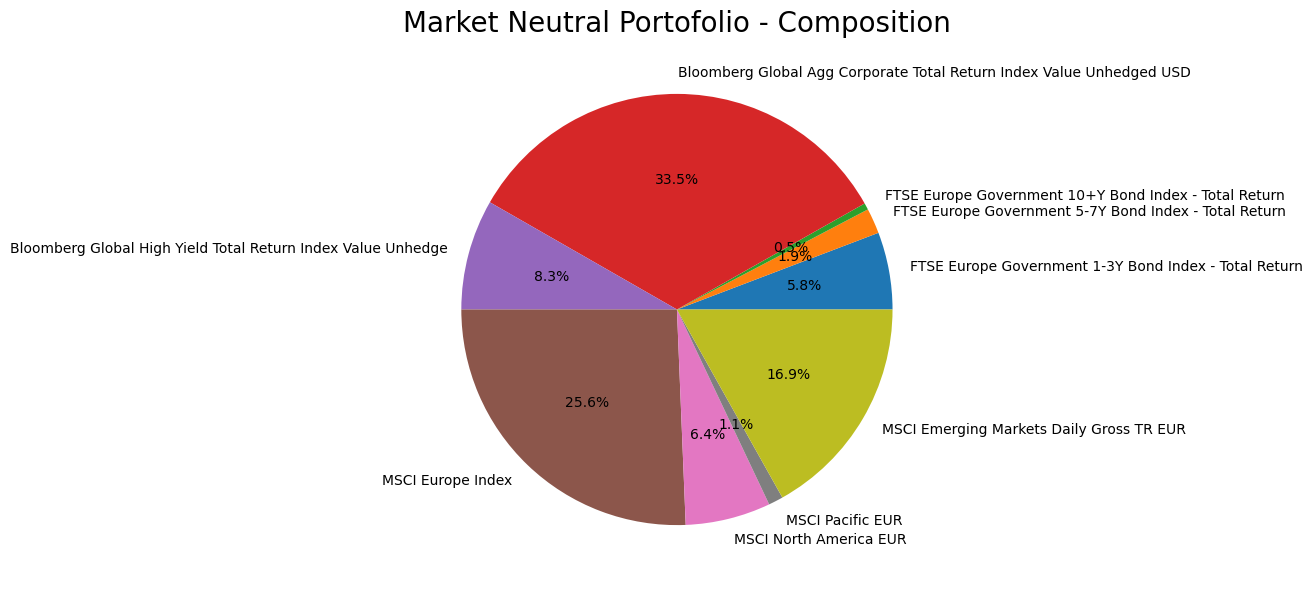

In [106]:
proxies = [
           'FTSE Europe Government 1-3Y Bond Index - Total Return',
           'FTSE Europe Government 5-7Y Bond Index - Total Return',
           'FTSE Europe Government 10+Y Bond Index - Total Return','Bloomberg Global Agg Corporate Total Return Index Value Unhedged USD',
           'Bloomberg Global High Yield Total Return Index Value Unhedge','MSCI Europe Index','MSCI North America EUR','MSCI Pacific EUR',
          'MSCI Emerging Markets Daily Gross TR EUR']
asset_classes = asset_returns.loc[:,proxies]


# Defining the market risk neutral portfolio
mkt_neutral = pd.Series([0.058, 0.019, 0.005, 0.336, 0.083, 0.257, 0.064, 0.011, 
                         0.169], index = asset_classes.columns)
fig = plt.figure(figsize =(10, 7))
plt.pie(mkt_neutral, labels = mkt_neutral.index, autopct='%1.1f%%')
plt.title('Market Neutral Portofolio - Composition', fontsize = 20)
plt.show()

The next phase of the analysis involves generating reliable and as precise as possible estimates for the expected return of each asset class. To accomplish this, I will adopt the method proposed by Black and Litterman:

\begin{align}
\pi = 2\hat{\lambda}\Sigma w_{mkt.neu.}
\end{align}

Here, $\pi$ represents the estimated equilibrium returns, $\lambda$ denotes the average risk aversion coefficient, and $\sum w_{mkt.neu}$ signifies the market-neutral weights.

To establish a value for $\lambda$, we will refer to the literature and adopt a risk aversion coefficient of 1.5. This parameter will be used in the calculations to determine the estimated equilibrium returns ($\pi$). 

I proceed applying to time series data (_asset_classes_) an exponential smoothing techniques (_EWM_) to estimate covariances.

In [107]:
first_observation = 146 # This is the first observation

# Calculate exponential weighted mean
ewm_means = asset_classes.ewm(alpha=0.98).mean()

# Extract means
ewm_means_at_index = ewm_means.loc[first_observation]

# Compute covariance manually using the exponential weighted means
cov_matrix_at_index = (asset_classes - ewm_means_at_index).ewm(alpha=0.98).mean().cov()

# Adjust covariance for annual basis
sigma = cov_matrix_at_index * 12

asset_stdev = asset_classes.std()*np.sqrt(12)
asset_stdev

FTSE Europe Government 1-3Y Bond Index - Total Return                   0.015827
FTSE Europe Government 5-7Y Bond Index - Total Return                   0.042597
FTSE Europe Government 10+Y Bond Index - Total Return                   0.109084
Bloomberg Global Agg Corporate Total Return Index Value Unhedged USD    0.069835
Bloomberg Global High Yield Total Return Index Value Unhedge            0.079248
MSCI Europe Index                                                       0.136175
MSCI North America EUR                                                  0.133581
MSCI Pacific EUR                                                        0.126190
MSCI Emerging Markets Daily Gross TR EUR                                0.142267
dtype: float64

The following analysis aims to visualizes the annualized standard deviations of different assets using a scatter plot, where each point represents an asset's standard deviation over time. The error bars indicate the standard error associated with these standard deviations, providing insights into the relative risk levels of various assets.

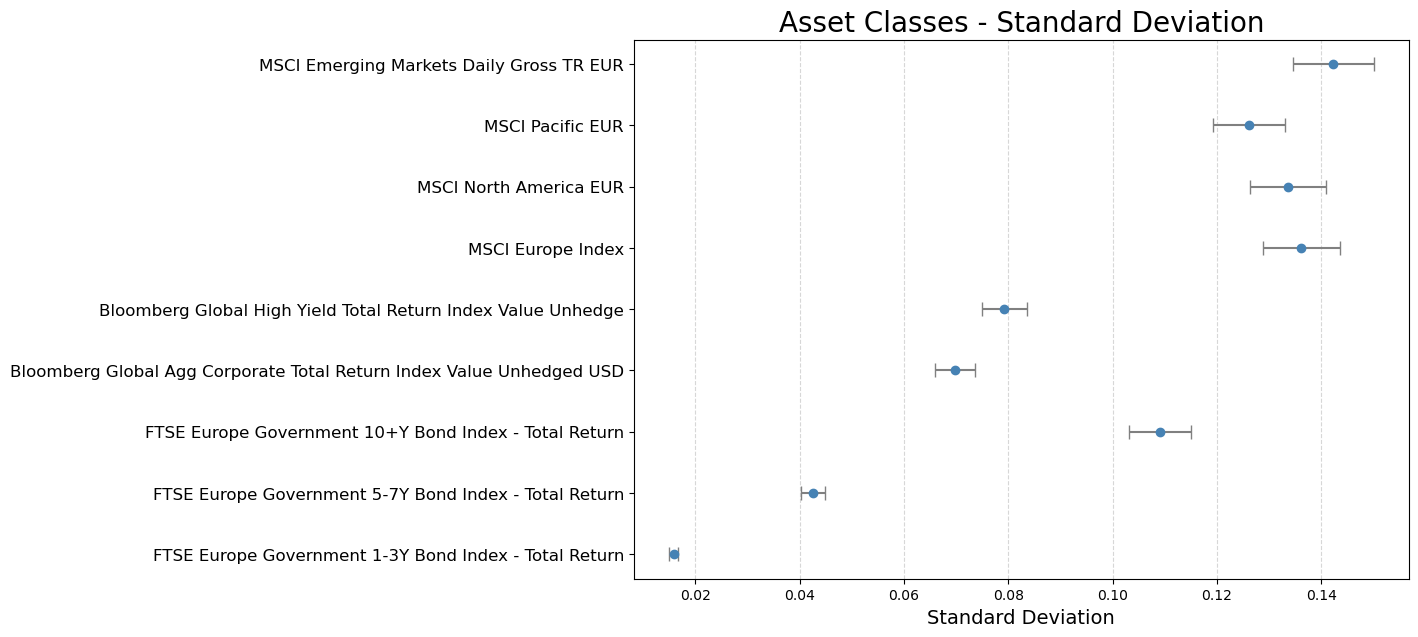

In [108]:
# Compute the annualized standard deviation of each asset class
asset_stdev_annualized = asset_classes.std() * np.sqrt(12)

# Calculate the number of observations
n = len(asset_classes)

# Calculate the standard error of the standard deviation
standard_error_std = asset_classes.std() / np.sqrt(2 * (n - 1))

# Scale the standard error for annualization
standard_error_std_annualized = standard_error_std * np.sqrt(12)

# Create a scatter plot with error bars for asset classes and standard deviations
fig, ax = plt.subplots(figsize=(10, 7))
y_pos = np.arange(len(asset_classes.columns))

ax.errorbar(
    asset_stdev_annualized, y_pos, xerr=standard_error_std_annualized,
    fmt='o', color='steelblue', ecolor='gray', capsize=5
)

ax.set_yticks(y_pos)
ax.set_yticklabels(asset_classes.columns, fontsize=12)
ax.set_xlabel('Standard Deviation', fontsize=14)
ax.set_title('Asset Classes - Standard Deviation', fontsize=20)
ax.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

From the first look to the scatter plot below, we can assume that:

**Equity Asset Class** exhibit the highest standard deviation.

- **MSCI Emerging Markets:** this index has the highest standard deviation of 14.2%, indicating it is the most volatile.
- **MSCI Pacific EUR and MSCI North America:** this indices have slightly lower standard deviations than the MSCI Emerging Markets, respectively 12.6% and 13.4% suggesting they might be less risky.
- **MSCI Europe Index:** with a standard deviation of 13.6%, this index may be less volatile than the MSCI Emerging Markets but more volatile than MSCI Pacific and North America.

**Bond Asset Class** have clearly a lower standard deviation, except for _FTSE Europe Government 10+Y Bond Index_ that exhibit an high standard deviation. This phenomena could be reflects the inherent risks associated with longer duration government bonds.

The following code calculates the equilibrium returns for each asset class based on the Black-Litterman model, incorporating the investor's risk aversion level (_lambda_) and the covariance matrix of asset returns (_sigma_) weighted by market-neutral portfolio weights (_mkt_neutral_).

In [109]:
# Equilirbium returns

_lambda = 1.5
pi = 2*_lambda*np.dot(sigma, mkt_neutral)
pi = pd.Series(pi, index = asset_classes.columns)
pi

FTSE Europe Government 1-3Y Bond Index - Total Return                   0.001185
FTSE Europe Government 5-7Y Bond Index - Total Return                   0.003923
FTSE Europe Government 10+Y Bond Index - Total Return                   0.010986
Bloomberg Global Agg Corporate Total Return Index Value Unhedged USD    0.009968
Bloomberg Global High Yield Total Return Index Value Unhedge            0.015208
MSCI Europe Index                                                       0.026838
MSCI North America EUR                                                  0.026225
MSCI Pacific EUR                                                        0.024632
MSCI Emerging Markets Daily Gross TR EUR                                0.026542
dtype: float64

Follows a graphical representation of the expected returns of each asset:

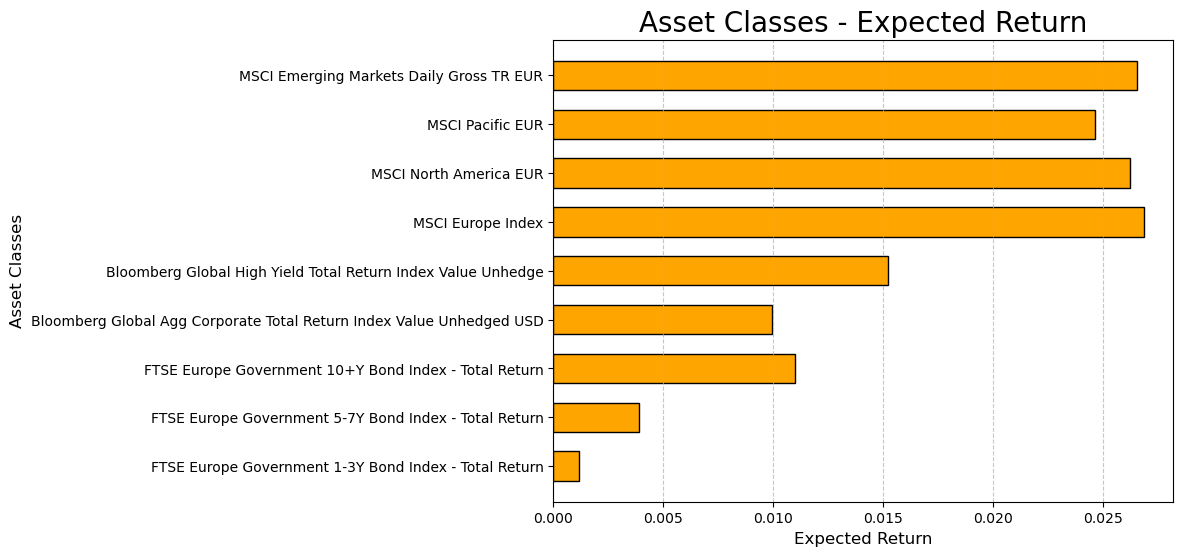

In [110]:
plt.figure(figsize=(8, 6))  # figure size

# Plot horizontal bars
bars = plt.barh(asset_classes.columns, pi, color='orange', edgecolor='black', height=0.6)

# Title and axis labels
plt.title('Asset Classes - Expected Return', fontsize=20)
plt.xlabel('Expected Return', fontsize=12)
plt.ylabel('Asset Classes', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7) 

for bar in bars:
    bar.set_edgecolor('black')

plt.show()

The following plot expose the unique return-risk profiles presented by each asset class.

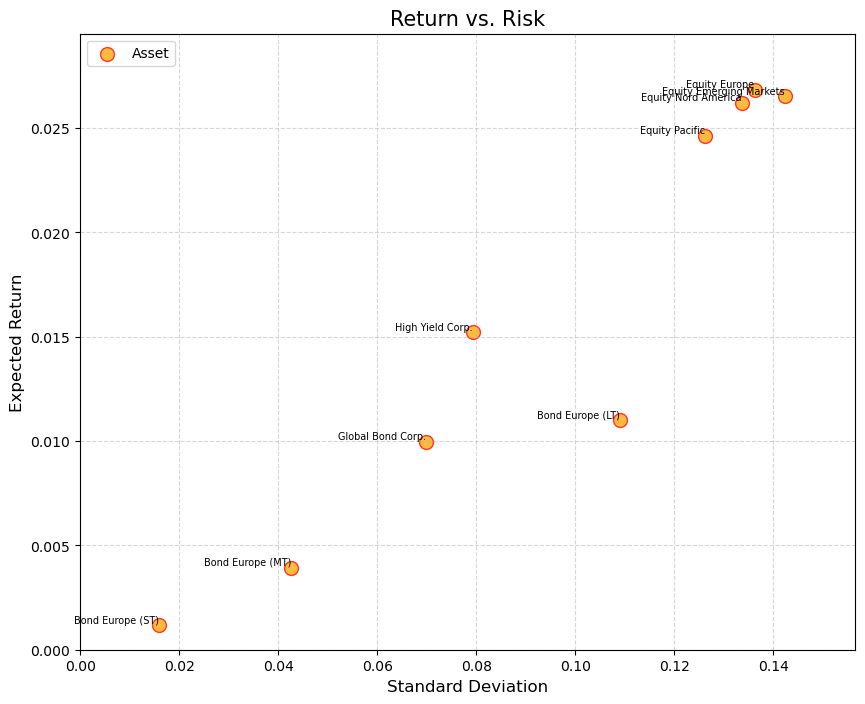

In [111]:
lab = ['Bond Europe (ST)', 'Bond Europe (MT)', 'Bond Europe (LT)', 'Global Bond Corp.',
       'High Yield Corp.', 'Equity Europe', 'Equity Nord America', 'Equity Pacific', 'Equity Emerging Markets']

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(asset_stdev, pi, s=100, c='orange', edgecolors='red', alpha=0.75, label='Asset')

# Annotate each point with asset label
for x, y, text in zip(asset_stdev, pi, lab):
    plt.text(x, y, text, fontsize=7, ha='right', va='bottom')

# Set plot title and axis labels
plt.title('Return vs. Risk', fontsize=15)
plt.xlabel('Standard Deviation', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=10)
plt.xlim(0, max(asset_stdev) * 1.1)
plt.ylim(0, max(pi) * 1.1)

plt.show()

## Portfolio Optimization

Now that we have our estimated expected returns without incorporating any investor insights or views, we will proceed with portfolio optimization by imposing constraints on the portfolio composition and using the equilibrium returns as proxies for expected returns. In a later phase, we will incorporate views on the performances of our asset classes. 

In [112]:
portfolios = pd.DataFrame(columns = ['Mkt Nt','Const. MV', 'BL'], index = asset_classes.index)
portfolios.loc[:,'Mkt Nt'] = np.dot(asset_classes, mkt_neutral)

Below, I will define several functions that will be useful for the remainder of the analysis:

- **port_ret(w,mu,annual)**. Calculates the annualized portfolio expected return based on portfolio weights and the expected returns of portfolio components.
- **port_var(w,S,annual)**. This function computes the annualized portfolio variance using portfolio weights and the covariance matrix of portfolio components.
- **port_sr(w,mu,S,annual)**. This function calculates the annualized Sharpe ratio of a portfolio given its weights, expected returns, and covariance matrix.
- **port_sr_opt(w,mu,S,annual)**. This function is the objective function used for optimization, it returns the negative of the Sharpe ratio to be minimized by the optimizer.

For all the functions the annual parameter is used to scales the results to an annual basis. 

In [113]:
def port_ret(w,mu,annual):
    """
    Return the annualized portfolio expected return as a function of the portfolio weights and of the expected returns of the 
    portfolio components.
    """
    return np.dot(w,mu)*annual

def port_var(w,S,annual):
    """
    Return the annualized portfolio variance as a function of the portfolio weights and of the covariance matrix of the 
    portfolio components.
    """
    return np.dot(np.dot(w,S),w)*annual

def port_sr(w,mu,S,annual):
    '''
    Return the annualized portfolio sharpe ratio as a function of the portfolio weights, the expected returns of the 
    portfolio components and their covariance matrix.
    '''
    a = np.dot(w,mu)*annual
    b = np.sqrt(np.dot(np.dot(w,S),w)*annual)
    return a/b

def port_sr_opt(w,mu,S,annual):
    a = np.dot(w,mu)*annual
    b = np.sqrt(np.dot(np.dot(w,S),w)*annual)
    return -a/b

In [114]:
print('The expected market neutral portfolio return is: {0}'.format(port_ret(mkt_neutral,pi,1)))
print('The market neutral portfolio variance is: {0}'.format(port_var(mkt_neutral,sigma,1)))
print('The market neutral portfolio Sharpe ratio is: {0}'.format(port_sr(mkt_neutral,pi,sigma,1)))

The expected market neutral portfolio return is: 0.018142075304600533
The market neutral portfolio variance is: 0.006047358434866845
The market neutral portfolio Sharpe ratio is: 0.23329429035834032


- The calculated expected return of the market-neutral portfolio is approximately 1.81%. This represents the anticipated average return of the portfolio based on the specified equilibrium returns.
- The variance of the market-neutral portfolio is calculated to be approximately 0.6%. This measures the dispersion of returns around the expected return, indicating the level of risk associated with the portfolio.
- The Sharpe ratio of the market-neutral portfolio is about 0.23. 

I will now implement additional risk metrics like:

- Value at Risk (VaR), at 5% confidence level.
- Conditional Value at Risk (CVaR), to estimate the average loss beyond the VaR threshold.

In [115]:
confidence_level = 0.05  # 5% confidence level

var_5 = np.percentile(portfolios['Mkt Nt'], 100 * confidence_level)
cvar_5 = portfolios['Mkt Nt'][portfolios['Mkt Nt'] <= var_5].mean()

print(f"Value at Risk (5%): {var_5:.2f}")
print(f"Conditional Value at Risk (5%): {cvar_5:.2f}")

Value at Risk (5%): -0.03
Conditional Value at Risk (5%): -0.05


In order to analyze the sources of portfolio returns through performance attribution, I will distinguish between asset allocation decisions and security selection:

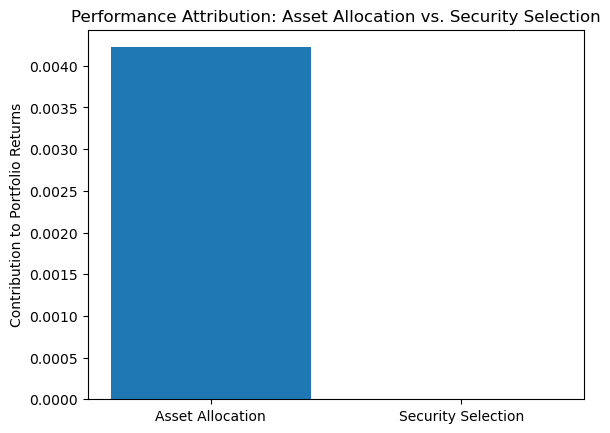

In [116]:
asset_allocation_returns = np.dot(mkt_neutral, asset_classes.mean())  # Contribution from asset allocation
security_selection_returns = portfolios['Mkt Nt'] - asset_allocation_returns  # Contribution from security selection

# Plot the breakdown of returns
plt.bar(['Asset Allocation', 'Security Selection'], [asset_allocation_returns.sum(), security_selection_returns.sum()])
plt.title('Performance Attribution: Asset Allocation vs. Security Selection')
plt.ylabel('Contribution to Portfolio Returns')
plt.show()

For the market neutral portfolio, where all asset classes are utilized, the entire performance can be attributed only to asset allocation decisions.

I will now establish weight constraints for each asset class, defining boundaries that regulate the allocation of weights. The table below illustrates the assigned bounds for each asset class. The objective is to prevent short selling by mandating that each weight remains positive. Additionally, the upper bound is set slightly higher than the corresponding market-neutral weight.

In [119]:
bounds = pd.DataFrame(index=pi.index, columns = ['min','max'])
bounds['min'] = 0
bounds.loc[:,'max'] = mkt_neutral + 0.1
bnds = [(bounds.loc[i,'min'],bounds.loc[i,'max']) for i in bounds.index]
bounds

,min,max
FTSE Europe Government 1-3Y Bond Index - Total Return,0,0.158
FTSE Europe Government 5-7Y Bond Index - Total Return,0,0.119
FTSE Europe Government 10+Y Bond Index - Total Return,0,0.105
Bloomberg Global Agg Corporate Total Return Index Value Unhedged USD,0,0.436
Bloomberg Global High Yield Total Return Index Value Unhedge,0,0.183
MSCI Europe Index,0,0.357
MSCI North America EUR,0,0.164
MSCI Pacific EUR,0,0.111
MSCI Emerging Markets Daily Gross TR EUR,0,0.269


Initially, I will define a constraint for bond and safe asset exposure. The goal is to optimize the portfolio composition across various levels of bond exposure and select the one that best aligns with the investor's preferences. Additionally, I will introduce several other constraints, including overall exposure to Bond asset class, European markets and relative exposure to Emerging Markets Equity compared to the entire equity class.

The following functions are defined to manage constraints related to bond exposure:

- **def Bond_exp(w, flag).** This function calculates the overall exposure of the bond class, represented by the weights and a flag that indicates if each asset belongs to the bond class (flag value of 1).
- **def Bond_exp_const(w,flag,target).** This function returns the constraint for the total bond exposure in the portfolio (target). It calculates the difference between the actual bond exposure and the specified target bond exposure.

In [120]:
def Bond_exp(w, flag):
    '''
    Overall exposure of the Bond class in the portfolio.
    '''
    x = pd.Series(w, flag.index)
    return x.loc[flag == 1].sum()

def Bond_exp_const(w,flag,target):
    '''
    Returns the Bond total exposure constraint.
    '''
    return Bond_exp(w,flag) - target

flag_bond = pd.Series(0,index = pi.index)
flag_bond[[
           'FTSE Europe Government 1-3Y Bond Index - Total Return',
           'FTSE Europe Government 5-7Y Bond Index - Total Return',
           'FTSE Europe Government 10+Y Bond Index - Total Return',
           'Bloomberg Global Agg Corporate Total Return Index Value Unhedged USD',
           'Bloomberg Global High Yield Total Return Index Value Unhedge']] = 1

The same procedure is made for the EU exposure.

In [121]:
def EU_exposure(w,flag):
    '''
    Overall exposure to the European Markets in the portfolio.
    '''
    x = pd.Series(w, flag.index)
    return x.loc[flag == 1].sum()

def EU_exposure_const(w,flag,target):
    return EU_exposure(w,flag) - target

EU_flag = pd.Series(0,index = pi.index)
EU_flag[[
        'FTSE Europe Government 1-3Y Bond Index - Total Return',
        'FTSE Europe Government 5-7Y Bond Index - Total Return',
        'FTSE Europe Government 10+Y Bond Index - Total Return',
        'MSCI Europe Index']] = 1

The aim is also to ensure that the relative exposure to emerging markets equity exceeds a specified threshold, given the intention to construct an assertive portfolio strategy.

In [122]:
def emerging_rel_exp(w,flag_equity,flag_emerging):
    '''
    Returns exposure to the Equity Emerging Markets relatively to overall Equity in the portfolio
    '''
    x = pd.Series(w,index = flag_equity.index)
    return x.loc[flag_emerging == 1].sum()/x.loc[flag_equity == 1].sum()

def emerging_rel_const(w,flag_equity,flag_emerging,target):
    return emerging_rel_exp(w,flag_equity,flag_emerging) - target

flag_equity = pd.Series(0,index = pi.index)
flag_EM = pd.Series(0, index = pi.index)

flag_equity[['MSCI Europe Index','MSCI North America EUR','MSCI Pacific EUR','MSCI Emerging Markets Daily Gross TR EUR']] = 1
flag_EM[['MSCI Emerging Markets Daily Gross TR EUR']] = 1

In addition to the initial bounds I've set, I'll introduce further constraints to enhance portfolio diversification. Specifically:

- Exposure to European Markets (both Bond and Equity Markets) must exceed 30%.
- The percentage of Emerging Market Equity should constitute at least 20% of the total Equity portion of the portfolio.

In [129]:
target_bond_exp = np.arange(0.1,1,0.1)
target_EU = 0.3
target_EM = 0.2

annual = 1
weights = pd.DataFrame(index = pi.index, columns = target_bond_exp)
Eff_Front = pd.DataFrame(index = target_bond_exp, columns = ['Mu','Var'])
w0 = pd.Series(1/len(mkt_neutral), index = pi.index) # Initializer

for expo in target_bond_exp:
    
    const = ({'type':'eq', 'fun':lambda w: sum(w) - 1},
            {'type':'eq', 'fun': Bond_exp_const, 'args':(flag_bond, expo)},
            {'type':'ineq', 'fun': EU_exposure_const,'args':(EU_flag, target_EU)},
            {'type':'ineq','fun': emerging_rel_const,'args':(flag_equity, flag_EM, target_EM)},)
    
    res = spopt.minimize(port_sr_opt, w0, args = (pi, sigma, annual), bounds = bnds, method = 'SLSQP',
                         constraints = const, options={'disp':False, 'ftol':1e-10,'maxiter':1000})
    
    weights[expo] = res.x
    
    Eff_Front.loc[expo,'Mu'] = port_ret(res.x, pi, annual)
    Eff_Front.loc[expo,'Var'] = port_var(res.x, sigma, annual)

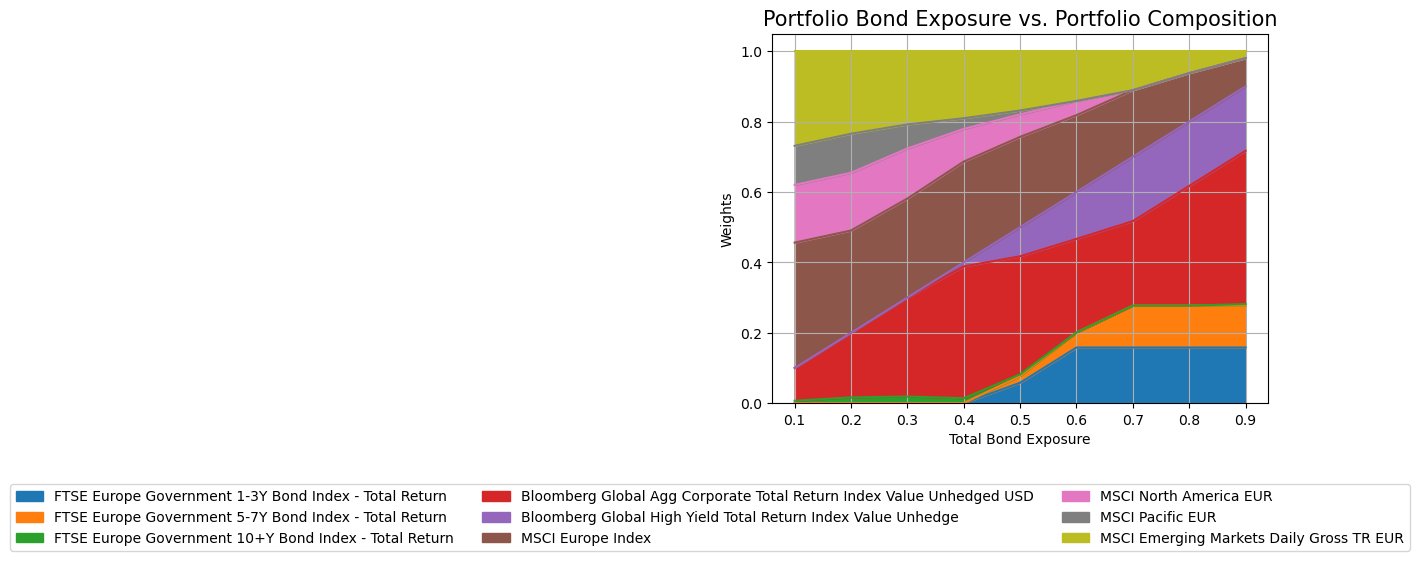

In [130]:
ax = (weights.T).plot.area()
ax.grid(True)
ax.legend(bbox_to_anchor=(1.3, -0.2), fancybox=True, ncol=3, loc='best')
plt.title('Portfolio Bond Exposure vs. Portfolio Composition', fontsize = 15)
plt.xlabel('Total Bond Exposure')
plt.ylabel('Weights')
plt.show()

Now, let's analyze the performance of the portfolio.

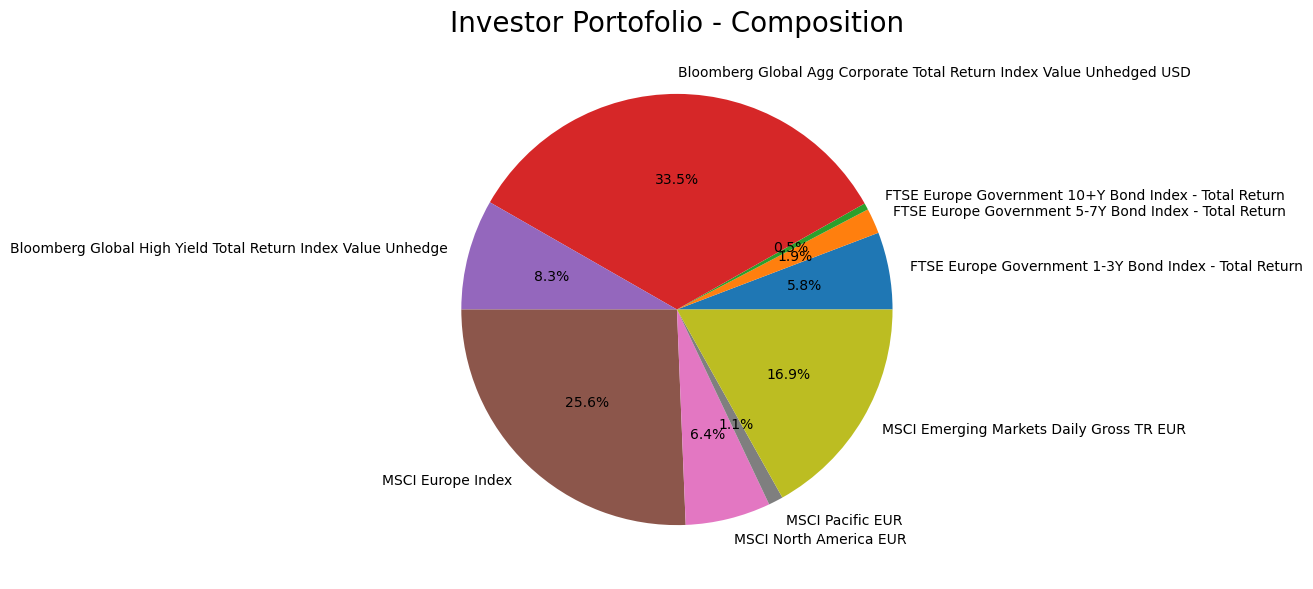

In [131]:
investor = weights.loc[:,0.5]
portfolios.loc[:,'Const. MV'] = np.dot(asset_classes, investor)
fig = plt.figure(figsize =(10, 7))
plt.pie(investor, labels = mkt_neutral.index, autopct='%1.1f%%')
plt.title('Investor Portofolio - Composition', fontsize = 20)
plt.show()

As we can see from the graph, the portfolio achieves a very nice degree of diversification. Its composition spreads among almost all the classes that we have considered so far and prevents any sort of concentration. Below some key quantities are displayed.

In [132]:
print('The expected market neutral portfolio return is: {0}'.format(port_ret(investor,pi,1)))
print('The market neutral portfolio variance is: {0}'.format(port_var(investor,sigma,1)))
print('The market neutral portfolio Sharpe ratio is: {0}'.format(port_sr(investor,pi,sigma,1)))

The expected market neutral portfolio return is: 0.01810580647008766
The market neutral portfolio variance is: 0.006023203381187598
The market neutral portfolio Sharpe ratio is: 0.2332942903522835


I now conduct the same risk and performance attribution analysis as above:

In [133]:
confidence_level = 0.05  # 5% confidence level

var_5 = np.percentile(portfolios['Const. MV'], 100 * confidence_level)
cvar_5 = portfolios['Const. MV'][portfolios['Const. MV'] <= var_5].mean()

print(f"Value at Risk (5%): {var_5:.2f}")
print(f"Conditional Value at Risk (5%): {cvar_5:.2f}")

Value at Risk (5%): -0.03
Conditional Value at Risk (5%): -0.05


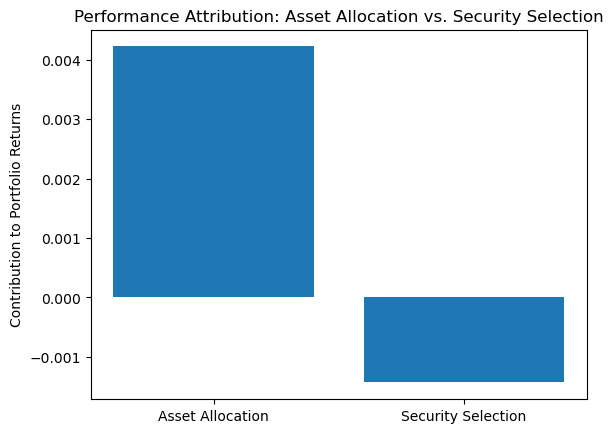

In [134]:
asset_allocation_returns = np.dot(mkt_neutral, asset_classes.mean())  # Contribution from asset allocation
security_selection_returns = portfolios['Const. MV'] - asset_allocation_returns  # Contribution from security selection

# Plot the breakdown of returns
plt.bar(['Asset Allocation', 'Security Selection'], [asset_allocation_returns.sum(), security_selection_returns.sum()])
plt.title('Performance Attribution: Asset Allocation vs. Security Selection')
plt.ylabel('Contribution to Portfolio Returns')
plt.show()

In this scenario, there is a decline in performance attributable to security selection.

## Black-Litterman

The next step involves incorporating views on the future expected performances of asset classes to refine the vector of expected returns for the portfolio. We have the following views:

- North America Equity is expected to outperform Europe Equity by 2% with medium confidence.
- High Yield Bonds are expected to outperform Global Corporate Bonds by 5% with high confidence.
- Emerging Markets Equity is expected to outperform Pacific Equity by 2.5% with medium confidence.

Following Meucci (2010), we define the Omega matrix as $\Omega = \frac{1}{c}P'\Sigma P$, where $c$ represents an overall level of confidence for the views (ranging from 0 to infinity).

For the implementation of the Black-Litterman (BL) model I need to define some variables:

- Q is the vector of views on the expected returns of asset classes, in which each element represents an expected return difference (outperformance).
- P is the matrix representing the mapping of views (Q) to asset returns (pi), here each row corresponds to a different view.
- tau is a constant representing the confidence level of the views (in this case 1) divided by the time horizon of the estimation.
- omega is the variance-covariance matrix of the views.

In [137]:
Q = np.array([0.02, 0.05, 0.025])
P = np.array([[0,0,0,0,0,-1,1,0,0],
            [0,0,0,-1,1,0,0,0,0],
            [0,0,0,0,0,0,0,-1,1]])

tau = 1/23 # set c = 1.
omega = P.dot(sigma.dot(P.T))

first_term= np.linalg.inv(np.linalg.inv(tau*sigma) + np.matmul(P.T, np.matmul(np.linalg.inv(omega), P)))
second_term= np.matmul(np.linalg.inv(tau*sigma), pi) + np.matmul(P.T, np.matmul(np.linalg.inv(omega), Q))

# The BL posterior returns are:
mu_bl = pd.Series(np.dot(first_term, second_term), index = pi.index)
mu_bl

FTSE Europe Government 1-3Y Bond Index - Total Return                   0.001127
FTSE Europe Government 5-7Y Bond Index - Total Return                   0.003600
FTSE Europe Government 10+Y Bond Index - Total Return                   0.010005
Bloomberg Global Agg Corporate Total Return Index Value Unhedged USD    0.009969
Bloomberg Global High Yield Total Return Index Value Unhedge            0.017074
MSCI Europe Index                                                       0.029451
MSCI North America EUR                                                  0.029696
MSCI Pacific EUR                                                        0.027026
MSCI Emerging Markets Daily Gross TR EUR                                0.029898
dtype: float64

The objective is now optimize the portfolio weights incorporating views on market behavior. The optimization method remain the same.

In [138]:
target_bond_exp = np.arange(0.1,1,0.1)
target_EU = 0.3
target_EM = 0.2

annual = 1
weights_bl = pd.DataFrame(index = pi.index, columns = target_bond_exp)
Eff_Front_bl = pd.DataFrame(index = target_bond_exp, columns = ['Mu','Var'])
w0 = pd.Series(1/len(mkt_neutral), index = pi.index) # Initializer

for expo in target_bond_exp:
    
    const = ({'type':'eq', 'fun':lambda w: sum(w) - 1},
            {'type':'eq', 'fun': Bond_exp_const, 'args':(flag_bond, expo)},
            {'type':'ineq', 'fun': EU_exposure_const,'args':(EU_flag, target_EU)},
            {'type':'ineq','fun': emerging_rel_const,'args':(flag_equity, flag_EM, target_EM)},)
    
    res = spopt.minimize(port_sr_opt, w0, args = (mu_bl, sigma, annual), bounds = bnds, method = 'SLSQP',
                         constraints = const, options={'disp':False, 'ftol':1e-10,'maxiter':1000})
    
    weights_bl[expo] = res.x
    
    Eff_Front_bl.loc[expo,'Mu'] = port_ret(res.x, mu_bl, annual)
    Eff_Front_bl.loc[expo,'Var'] = port_var(res.x, sigma, annual)

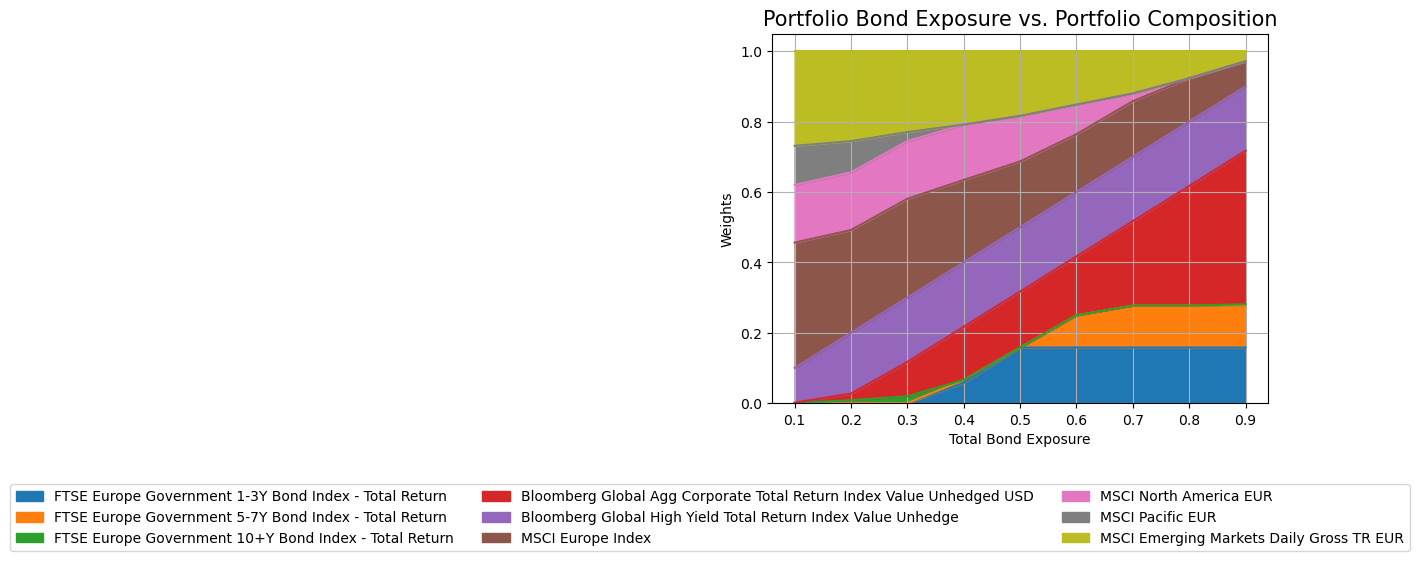

In [139]:
ax = (weights_bl.T).plot.area()
ax.grid(True)
ax.legend(bbox_to_anchor=(1.3, -0.2), fancybox=True, ncol=3, loc='best')
plt.title('Portfolio Bond Exposure vs. Portfolio Composition', fontsize = 15)
plt.xlabel('Total Bond Exposure')
plt.ylabel('Weights')
plt.show()

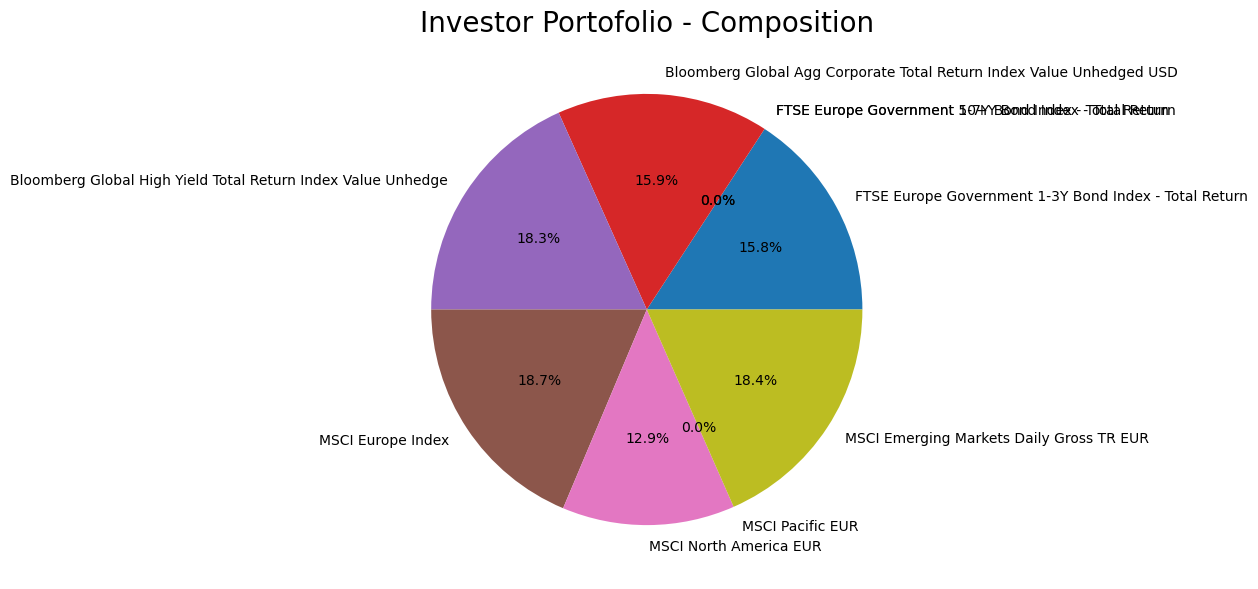

In [140]:
investor_bl = weights_bl.loc[:,0.5]
portfolios.loc[:,'BL'] = np.dot(asset_classes, investor_bl)
fig = plt.figure(figsize =(10, 7))
plt.pie(investor_bl, labels = mkt_neutral.index, autopct='%1.1f%%')
plt.title('Investor Portofolio - Composition', fontsize = 20)
plt.show()

The revised portfolio composition shows notable differences compared to the previous estimates. Notably, the weight allocated to the European Equity Market has been substantially reduced. The equity portion of the portfolio is now allocated in a higher percentage in North America Equity and Emerging Markets. Pacific equity has been completely removed from the portfolio. 

The adjustments made to the bond portion of the portfolio are more noticeable. Specifically, the allocations to Bond High Yield and EU Bond Short-Term have increased, while the allocations to EU Bond Medium-Term and Long-Term are now zero.

Below, I present the usual statistics: 

The Sharpe Ratio has increased compared to the previous two portfolios, indicating improved performance. 
Interestingly, the portfolio variance is slightly reduced for effect of a more accentuated diversification.

In [141]:
print('The expected market neutral portfolio return is: {0}'.format(port_ret(investor_bl,mu_bl,1)))
print('The market neutral portfolio variance is: {0}'.format(port_var(investor_bl,sigma,1)))
print('The market neutral portfolio Sharpe ratio is: {0}'.format(port_sr(investor_bl,mu_bl,sigma,1)))

The expected market neutral portfolio return is: 0.019727326516169718
The market neutral portfolio variance is: 0.005911946469373566
The market neutral portfolio Sharpe ratio is: 0.256568293937358


Below, the ususal risk and performance attribution analysis:

In [142]:
confidence_level = 0.05  # 5% confidence level

var_5 = np.percentile(portfolios['BL'], 100 * confidence_level)
cvar_5 = portfolios['BL'][portfolios['BL'] <= var_5].mean()

print(f"Value at Risk (5%): {var_5:.2f}")
print(f"Conditional Value at Risk (5%): {cvar_5:.2f}")

Value at Risk (5%): -0.04
Conditional Value at Risk (5%): -0.05


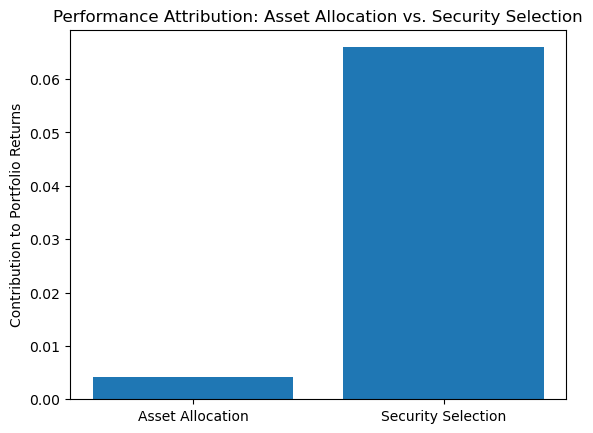

In [143]:
asset_allocation_returns = np.dot(mkt_neutral, asset_classes.mean())  # Contribution from asset allocation
security_selection_returns = portfolios['BL'] - asset_allocation_returns  # Contribution from security selection

# Plot the breakdown of returns
plt.bar(['Asset Allocation', 'Security Selection'], [asset_allocation_returns.sum(), security_selection_returns.sum()])
plt.title('Performance Attribution: Asset Allocation vs. Security Selection')
plt.ylabel('Contribution to Portfolio Returns')
plt.show() 

The majority of the portfolio's performance is attributed to security selection.

The plot below consist in a visualization of the cumulative return trends of the three examined portfolios.

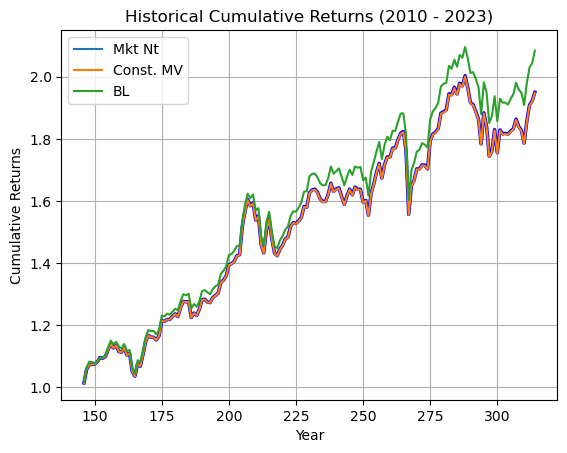

In [144]:
# Compute cumulative returns and plot
ax = (1 + portfolios).cumprod().plot()

# Plot
ax.set_title('Historical Cumulative Returns (2010 - 2023)')
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Returns')
ax.grid(True)
ax.lines[0].set_color('blue')  
ax.lines[0].set_linestyle('-')  
ax.lines[0].set_linewidth(2.5)  

plt.show()

# Dynamic Asset Allocation

The following model aims to create an optimal portfolio for the investor with multiple objectives over various time horizons, using a dynamic asset allocation approach.

The assets considered are the same of the previous analysis.

I start defining the initial wealth of the investor and the additional investment for each year of the investment horizon, in particular:


- The initial wealth of the investor is equal to an amount of EUR 150000
- The investor will pay an additional sum on an annual basis of EUR 5000
- The investment time horizon is 30 years

In [165]:
initial_wealth = 150000

additional_investment = 5000

investment_horizon = 30

here we define the expenses that the investor will incur over the years, in particular:
- In 10 years, the investor will have to pay an amount of EUR 15000
- In 11 years, the investor will have to pay an amount of EUR 15000
- In 12 years, the investor will have to pay an amount of EUR 15000
- In 13 years, the investor will have to pay an amount of EUR 15000
- In 20 years, the investor will have to pay an amount of EUR 30000
- In 21 years, the investor will have to pay an amount of EUR 30000
- In 22 years, the investor will have to pay an amount of EUR 30000
- In 23 years, the investor will have to pay an amount of EUR 120000

In [166]:
goals = [
    {'year': 10, 'amount': 15000},
    {'year': 11, 'amount': 15000},
    {'year': 12, 'amount': 15000},
    {'year': 13, 'amount': 15000},
    {'year': 20, 'amount': 30000},
    {'year': 21, 'amount': 30000},
    {'year': 22, 'amount': 30000},
    {'year': 28, 'amount': 120000},
]

There is an overview on the purpose of each function:

- **simulate_bond_returns(self, beta0, beta1, beta2, beta3, tau1, tau2, maturity_term)**. Simulates bond assets returns using the Nelson-Siegel-Svensson (NSS) model. Takes as an input the parameters beta0, beta1, beta2, beta3, tau1, tau2 from ECB site, used to define the following model:

$$ y(t) = \beta_0 + \beta_1\left(\frac{1-e^{t/\tau_1}}{t/\tau_1}\right) + \beta_2\left(\frac{1-e^{t/\tau_1}}{t/\tau_1} - e^{-t/\tau_1}\right) + \beta_3\left(\frac{1-e^{t/\tau_2}}{t/\tau_2} - e^{-t/\tau_2}\right) $$

The term $t$ is calculated considering the maturity of the bond at each iteration (in this case the asset class "bonds" includes 1-3Y, 5-7Y and 10+Y maturities).

- **def simulate_stock_returns(self, mu, sigma, initial_price, investment_horizon)**. Simulates equity assets returns assuming that prices evolves following a Geometric Brownian Motion (GBM) model. The function take as inputs $\mu$ and $\sigma$ which are calculated as the mean values of the assets belonging the equity asset class. The model equation for prices $S(t)$ is given by:

$$ dS(t) = \mu S(t)dt + \sigma S(t)dW(t)$$

- **def generate_asset_returns(self)**. Generates returns for each asset based on its type (bond or stock) using the above methods.

- **def calculate_portfolio_performance(self, weights)**. Calculates the performance of a portfolio over the investment horizon based on given weights, this function incorporates annual returns and additional investments based on financial goals.

- **def fitness_function(self, weights)**. Evaluates the fitness of a portfolio based on how well it meets the specified financial goals.

- **def evolve_population(self, num_generations, population_size, initial_mutation_rate, final_mutation_rate)**. Implements a genetic algorithm to evolve the population of portfolios over several generations. The function utilizes selection, crossover, and mutation operations to optimize portfolio weights.

- **def interpolate_mutation_rate(self, initial_rate, final_rate, current_generation, total_generations)**. Interpolates the mutation rate between initial and final values based on the current generation. Returns interpolated mutation rate for the current generation.

- **def crossover(self, parent1, parent2)**. Performs uniform crossover between two parent portfolios. Returns child portfolio weights resulting from crossover.

- **mutate(self, portfolio_weights, mutation_rate)**. Randomly mutates some weights in the portfolio, in this context, "mutation_rate" controlling the probability of mutation. 

- **print_success_probability(self)**. Prints the success probability for each investment goal based on the optimal portfolio weights.

- **meets_investment_goals(self, weights)**.  Checks if a given portfolio allocation meets all investment goals. Returns a Boolean parameter (0 or 1) indicating if the goals are met.

- **select_optimal_portfolio(self)**. Selects the optimal dynamic asset allocation portfolio based on fitness scores. Returns the optimal asset allocation weights for the portfolio.

- **plot_portfolio_paths(self, num_samples)**. Plots sample portfolio paths along with the optimal portfolio path over the investment horizon.

- **plot_annual_optimal_weights(self)**. Plots the annual optimal portfolio weights over the investment horizon. Line plot showing the changes in asset weights over time.

In [167]:
class DynamicAssetAllocationModel:  
    
    
    def __init__(self, initial_population, investment_horizon, goals, probabilities, irrs, asset_classes, dataset):
        self.population = initial_population
        self.investment_horizon = investment_horizon
        self.goals = goals
        self.probabilities = probabilities
        self.irrs = irrs
        self.asset_classes = asset_classes
        self.dataset = dataset
        self.num_assets = len(asset_classes.columns)
        self.initial_wealth = initial_wealth
        self.additional_investment = additional_investment
        
    def simulate_bond_returns(self, beta0, beta1, beta2, beta3, tau1, tau2, maturity_term):
        """
        Bond asset simulation using Nelson-Siegel-Svensson (NSS) model.
    
        All beta and tau parameters are taken from the ECB site: 
        https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
    
        Updated at 27/04/2024
        """
        t = np.arange(1, self.investment_horizon + 1)

        if maturity_term == '1-3Y':
            t = np.minimum(t, 3)  # Cap t at 3 years for 1-3Y bonds
        elif maturity_term == '5-7Y':
            t = np.minimum(t, 7)  # Cap t at 7 years for 5-7Y bonds
        elif maturity_term == '10+Y':
            t = np.minimum(t, self.investment_horizon)  # Use investment horizon for 10+Y bonds

        # Calculate y components
        term1 = beta0
        term2 = beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1))
        term3 = beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1))
        term4 = beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2))

        y = term1 + term2 + term3 + term4

        # Calculate bond returns from y
        bond_returns = np.diff(y)
        bond_returns = np.concatenate(([0], bond_returns))

        return bond_returns

    def simulate_stock_returns(self, mu, sigma, initial_price, investment_horizon):
        
        """
        Stock asset simulation are calculated using a Geometric Brownian Motion (GBM) model.
        
        mu and sigma are extracted as the mean parameters of assets in the "equity" asset class.
        
        """
        dt = 1  # time step (annual)
        num_steps = investment_horizon
        returns = np.random.normal(mu * dt, sigma * np.sqrt(dt), size=num_steps)
        stock_prices = np.zeros(num_steps + 1)
        stock_prices[0] = initial_price
        for i in range(num_steps):
            next_price = stock_prices[i] * (1 + returns[i])
            stock_prices[i + 1] = next_price
        stock_returns = np.diff(np.log(stock_prices))
        
        return stock_returns

    def generate_asset_returns(self):
        
        asset_returns = np.zeros((self.investment_horizon, self.num_assets))

        bond_assets = {
            'FTSE Europe Government 1-3Y Bond Index - Total Return': '1-3Y',
            'FTSE Europe Government 5-7Y Bond Index - Total Return': '5-7Y',
            'FTSE Europe Government 10+Y Bond Index - Total Return': '10+Y',
            'Bloomberg Global Agg Corporate Total Return Index Value Unhedged USD': None,
            'Bloomberg Global High Yield Total Return Index Value Unhedge': None
        }

        for i, asset_name in enumerate(self.asset_classes.columns):
            if asset_name in bond_assets:
                # Bond asset simulation using Nelson-Siegel-Svensson (NSS) model
                maturity_term = bond_assets[asset_name]
                bond_returns = self.simulate_bond_returns(
                    beta0=0.800291,
                    beta1=3.085896,
                    beta2=-2.977309,
                    beta3=6.852752,
                    tau1=3.056478,
                    tau2=10.834817,
                    maturity_term=maturity_term
                )
                asset_returns[:, i] = bond_returns
            else:
                # Stock asset simulation using Geometric Brownian Motion (GBM) model
                asset_returns[:, i] = self.simulate_stock_returns(
                    mu=0.05639,
                    sigma=0.03884225,
                    initial_price=100,  # Example initial price, adjust as needed
                    investment_horizon=self.investment_horizon
                )

        return asset_returns

    def calculate_portfolio_performance(self, weights):
        
        """
        Calculate portfolio performance based on weights and asset returns.
        """

        portfolio_values = [self.initial_wealth]
        asset_returns = self.generate_asset_returns()  # Use self.asset_classes and self.dataset

        for year in range(1, self.investment_horizon + 1):
            # Calculate returns for each asset based on weights
            year_returns = asset_returns[year-1]
            portfolio_return = np.dot(weights, year_returns)

            # Calculate portfolio value for this year
            if year == 1:
                # First year: initial wealth + additional investment
                portfolio_value = portfolio_values[0]
            else:
                # Subsequent years: previous year's portfolio value + investment + returns
                portfolio_value = portfolio_values[-1] * (1 + portfolio_return) + self.additional_investment

            # Check and withdraw for each goal
            for goal in self.goals:
                goal_year = goal['year']
                if year == goal_year:
                    withdrawal_amount = goal['amount']
                    portfolio_value -= withdrawal_amount

            # Append the portfolio value for the current year
            portfolio_values.append(portfolio_value)

        return np.array(portfolio_values)
    
    def fitness_function(self, weights):
        
        """
        Evaluate fitness of a given portfolio based on performance, 
        based on the primary goal of minimum success probability and secondary goal of IRR shortfall
        """
        
        # Calculate portfolio performance over time
        final_portfolio_values = self.calculate_portfolio_performance(weights)
    
        # Initialize variables to track success and IRR shortfall
        success_count = 0
        total_irr_shortfall = 0
    
        # Evaluate each goal
        for goal in self.goals:
            goal_year = goal['year']
            goal_amount = goal['amount']
        
            if goal_year <= self.investment_horizon:
                portfolio_value_at_goal_year = final_portfolio_values[goal_year]
            
                # Check if the goal is met
                if portfolio_value_at_goal_year >= goal_amount:
                    success_count += 1
                
                # Calculate IRR shortfall if the goal is not met
                else:
                    irr_shortfall = goal_amount - portfolio_value_at_goal_year
                    total_irr_shortfall += irr_shortfall
    
        # Calculate success probability (fraction of goals met)
        success_probability = success_count / len(self.goals)
    
        # Fitness score prioritizes success probability, then minimizes IRR shortfall if successful
        fitness_score = success_probability  # Primary goal: maximize success probability
    
        if success_probability > 0:
            # If success probability is achieved, minimize expected shortfall of IRR
            fitness_score -= total_irr_shortfall / success_probability
    
        return fitness_score
    
    def evolve_population(self, num_generations, population_size, initial_mutation_rate, final_mutation_rate):
        
        """
        Evolve the population over multiple generations using genetic algorithm.
        """

        num_assets = len(self.asset_classes.columns)
        population = deepcopy(self.population)
        optimal_weights_history = []

        for generation in range(num_generations):
            # Evaluate fitness of each portfolio
            fitness_scores = [self.fitness_function(weights) for weights in population]

            # Select top portfolios based on fitness
            sorted_indices = np.argsort(fitness_scores)[::-1]
            elite_count = int(population_size * 0.3)  # Number of elite to keep
            elite_indices = sorted_indices[:min(elite_count, len(population))]  # Keep top elite_count as elite
            
            elite_indices = np.array(elite_indices).flatten()

            # Create new population through selection, crossover, and mutation
            new_population = []

            while len(new_population) < population_size:
                if len(elite_indices) < 2:
                    raise ValueError("Elite indices size is less than 2. Cannot perform crossover.")

                # Select two parents
                parent_indices = np.random.choice(elite_indices, size=2, replace=False)
                
                parent1_weights = population[parent_indices[0] % len(population)]  
                parent2_weights = population[parent_indices[1] % len(population)]
                
                child_weights = self.crossover(parent1_weights, parent2_weights)
                current_mutation_rate = self.interpolate_mutation_rate(initial_mutation_rate, final_mutation_rate, 
                                                                       generation, num_generations)
                child_weights = self.mutate(child_weights, current_mutation_rate)
                
                new_population.append(child_weights)

            population = new_population
            
            optimal_weights = population[np.argmax(fitness_scores)]
            optimal_weights_history.append(optimal_weights)
        
        self.population = population
        self.optimal_weights_history = optimal_weights_history
        
    def interpolate_mutation_rate(self, initial_rate, final_rate, current_generation, total_generations):
        
        """
        Interpolates the mutation rate linearly between initial and final rates based on the current generation progress.

        """
     
        progress = current_generation / total_generations
        return initial_rate + (final_rate - initial_rate) * progress
    
    def crossover(self, parent1, parent2):
        
        """
        Performs uniform crossover between two parent portfolios to generate a child portfolio.
        """
        
        # Uniform crossover
        child = []
        for i in range(len(parent1)):
            if np.random.rand() < 0.5:
                child.append(parent1[i])
            else:
                child.append(parent2[i])
        return child
    
    def mutate(self, portfolio_weights, mutation_rate):
        
        """
        Randomly mutates some weights in a portfolio based on a given mutation rate.
        """
        
        # Randomly mutate some weights
        mutated_weights = []
        for weight in portfolio_weights:
            if np.random.rand() < mutation_rate:
                mutated_weights.append(np.random.rand())
            else:
                mutated_weights.append(weight)
        return mutated_weights
    
    def print_success_probability(self):
        
        """
        Print the success probability for each investment goal year based on optimal portfolio weights history.
        
        """   
        
        if not hasattr(self, 'optimal_weights_history'):
            raise ValueError("Optimal portfolio weights history is not available. Please run the genetic algorithm.")

        success_count_by_goal = {goal['year']: 0 for goal in self.goals}

        for weights in self.optimal_weights_history:
            for goal in self.goals:
                goal_year = goal['year']
                goal_amount = goal['amount']
                if goal_year <= self.investment_horizon:
                    final_portfolio_values = self.calculate_portfolio_performance(weights)
                    portfolio_value_at_goal_year = final_portfolio_values[goal_year]
                    if portfolio_value_at_goal_year >= goal_amount:
                        success_count_by_goal[goal_year] += 1

        success_probability_by_goal = {
            goal['year']: success_count_by_goal[goal['year']] / len(self.optimal_weights_history) for goal in self.goals
        }

        for goal in self.goals:
            goal_year = goal['year']
            print(f"Success Probability for Goal at Year {goal_year}: {success_probability_by_goal[goal_year]:.2%}")

    
    def meets_investment_goals(self, weights):
        
        """
        Check if the portfolio meets all investment goals within the investment horizon.

        """
        
        final_portfolio_values = self.calculate_portfolio_performance(weights)
        
        for goal in self.goals:
            goal_year = goal['year']
            goal_amount = goal['amount']
            if goal_year <= self.investment_horizon:
                portfolio_value_at_goal_year = final_portfolio_values[goal_year]
                if portfolio_value_at_goal_year < goal_amount:
                    return False
        
        return True
    
    def select_optimal_portfolio(self):
        
        """
        Selects the optimal dynamic asset allocation based on the genetic algorithm results.

        """
        
        # Select the optimal dynamic asset allocation
        if not self.population:
            raise ValueError("Population is empty. Please run the genetic algorithm to populate the population.")
        
        # Evaluate fitness of each portfolio in the population
        fitness_scores = [self.fitness_function(weights) for weights in self.population]
        
        if len(fitness_scores) == 0 or np.any(np.isnan(fitness_scores)):
            raise ValueError("Fitness scores are invalid or empty. Cannot determine optimal portfolio.")
            
        try:
            best_portfolio_index = np.nanargmax(fitness_scores)
        except ValueError:
            raise ValueError("Unable to determine the best portfolio index. Check fitness scores and population.")
        
        if best_portfolio_index < 0 or best_portfolio_index >= len(self.population):
            raise ValueError(f"Invalid best_portfolio_index: {best_portfolio_index}. "
                             f"It should be within the range [0, {len(self.population) - 1}].")
        
        optimal_weights = self.population[best_portfolio_index]
        asset_names = list(self.asset_classes.columns)
        
        optimal_weights /= np.sum(optimal_weights)

        return optimal_weights

    def plot_portfolio_paths(self, num_samples=10):
        
        """
        Plot multiple sample portfolio paths along with the optimal portfolio path.

        """
        
        plt.figure(figsize=(12, 8))
        
        for i in range(num_samples):
            weights = np.random.rand(len(self.asset_classes.columns))
            weights /= np.sum(weights)  # Normalize to ensure sum(weights) = 1
            portfolio_values = self.calculate_portfolio_performance(weights)
            plt.plot(range(self.investment_horizon + 1), portfolio_values, alpha=0.5, label=f'Portfolio {i+1}')
        
        optimal_weights = self.select_optimal_portfolio()
        optimal_portfolio_values = self.calculate_portfolio_performance(optimal_weights)
        plt.plot(range(self.investment_horizon + 1), optimal_portfolio_values, 'r-', linewidth=2, 
                 label='Optimal Portfolio')

        plt.xlabel('Years')
        plt.ylabel('Portfolio Value')
        plt.title('Portfolio Paths')
        custom_legend = [
            Line2D([0], [0], color='red', linewidth=2), 
            Line2D([0], [0], color='blue', linewidth=1), 
        ]
        legend_labels = ['Optimal Portfolio'] + ['Other Portfolios']
        
        plt.legend(custom_legend, legend_labels)
        
        plt.show()
        
    def plot_annual_optimal_weights(self):
        
        """
        Plot the annual optimal portfolio weights over the investment horizon.

        """
        
        if not hasattr(self, 'optimal_weights_history'):
            raise ValueError("Optimal portfolio weights history is not available. Please run the genetic algorithm.")
    
        optimal_weights_history = np.array(self.optimal_weights_history)
        num_assets = len(self.asset_classes.columns)
        asset_names = list(self.asset_classes.columns)
        investment_horizon = self.investment_horizon
    
        annual_optimal_weights = np.zeros((investment_horizon, num_assets))

        # Aggregate optimal weights by year
        for year in range(investment_horizon):
            year_weights = optimal_weights_history[year::investment_horizon, :]  # Select weights for each year
            annual_optimal_weights[year, :] = np.mean(year_weights, axis=0)  # Calculate mean weights for the year

        annual_optimal_weights = annual_optimal_weights / np.sum(annual_optimal_weights, axis=1, keepdims=True)

        # Plot annual optimal portfolio weights
        plt.figure(figsize=(12, 8))
        for asset_index in range(num_assets):
            plt.plot(range(1, investment_horizon + 1), annual_optimal_weights[:, asset_index], 
                     label=asset_names[asset_index])
    
        plt.xlabel('Investment Year')
        plt.ylabel('Portfolio Weight')
        plt.title('Annual Optimal Portfolio Weights Over Investment Horizon')
        plt.legend()
        plt.show()

The purpose of the following lines is to create an initial set of portfolios for use in the genetic algorithm.
Each portfolio is represented as a row in the _initial_population_ matrix, where each element (or column) within a row corresponds to the weight of a specific asset in that portfolio. The matrix _initial_population_ is populated with random values using _np.random.rand_, which generates numbers uniformly distributed between 0 and 1. These random values represent the initial allocation (weights) of assets in each portfolio.

In [168]:
# Define the initial population of portfolios
num_portfolios = 100

num_assets = len(asset_classes.columns)
initial_population = np.random.rand(num_portfolios, num_assets)

Here, _probabilities_ is a dictionary that stores specific probabilities related to investment scenarios:
- 'min_success': Represents the minimum success probability required for an investment to be deemed successful. In this case, it's set to 0.975 (or 97.5%).
Similarly, _irrs_ is another dictionary used to store internal rates of return (IRRs) related to investment scenarios. The key within this dictionary is:
- 'average_irr_worst_cases': Represents the average IRR across worst-case investment scenarios. It's set to None, indicating that this value is not specified.

In [169]:
# Define probabilities and IRRs
probabilities = {'min_success': 0.975}
irrs = {'average_irr_worst_cases': None}

The following lines sets up and executes the dynamic asset allocation model through the class: "_DynamicAssetAllocationModel_" to manage investment portfolios over the specified time horizon (investment_horizon).

During the evolution process, the genetic algorithm adjusts the population's portfolio weights through crossover and mutation operations, aiming to maximize the model's fitness function (likely based on success probabilities and IRRs):

- the mutation rate starts and remains constant (_initial_ and _final_ mutation rate =0.4), indicating a consistent level of portfolio weight adjustment throughout the algorithm's execution.

In [170]:
model = DynamicAssetAllocationModel(initial_population, investment_horizon, goals, probabilities, irrs, asset_classes, dataset)
model.evolve_population(num_generations=150, population_size=200, initial_mutation_rate=0.4, final_mutation_rate=0.4)

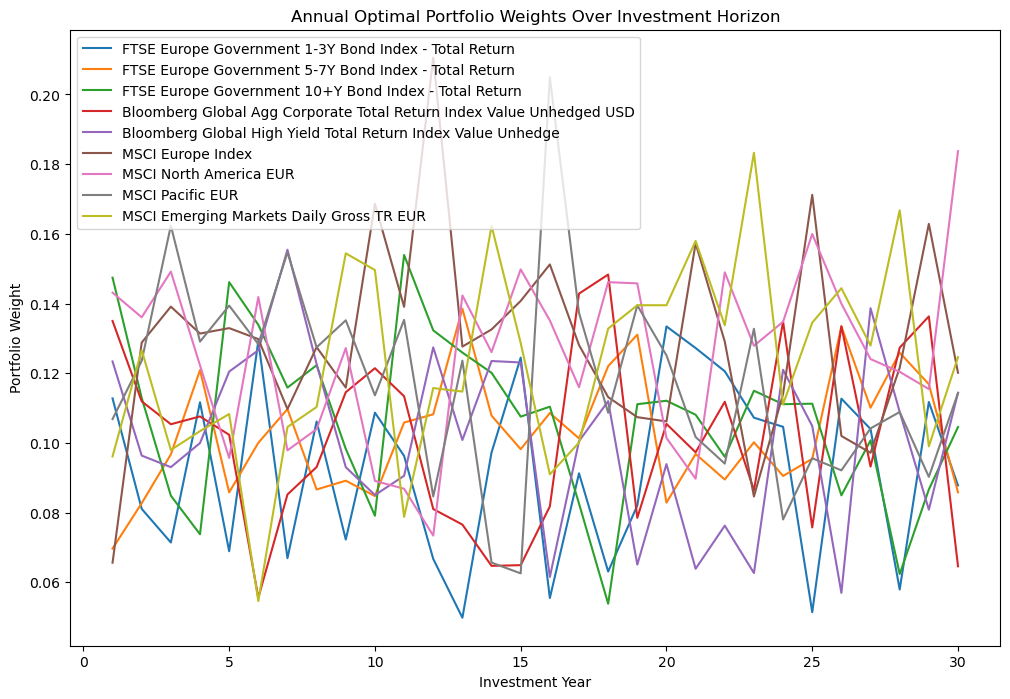

In [171]:
model.plot_annual_optimal_weights()

The plot above show the optimal portfolio's weights adjustment for each asset during the investment horizon.

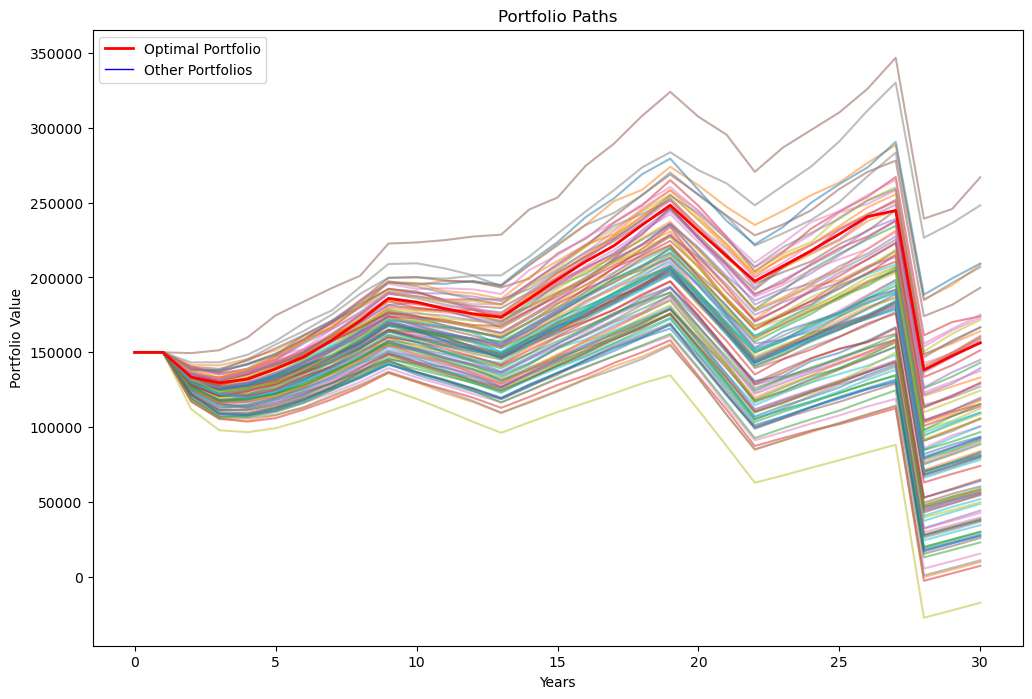

In [172]:
model.plot_portfolio_paths(num_samples=100)

The optimal portfolio is chosen based on the evaluation of the fitness function, which quantifies how well a particular portfolio meets the investment goals. The fitness function considers the following factors:

- Success Probability: The likelihood that the portfolio will achieve specific investment goals within the defined investment horizon.
- IRR (Internal Rate of Return) Shortfall: If the investment goals are not fully met, the fitness function may penalize portfolios based on the degree of shortfall relative to the target.

The optimal portfolio displayed is selected as the portfolio with the highest fitness score (or lowest fitness penalty, in case all goals are not fully met). The optimal portfolio is chosen on maximizing the likelihood of achieving investment objectives (success probability) while minimizing the risk of underperformance (IRR shortfall).

# Success probability

In [173]:
model.print_success_probability()

Success Probability for Goal at Year 10: 100.00%
Success Probability for Goal at Year 11: 100.00%
Success Probability for Goal at Year 12: 100.00%
Success Probability for Goal at Year 13: 100.00%
Success Probability for Goal at Year 20: 100.00%
Success Probability for Goal at Year 21: 100.00%
Success Probability for Goal at Year 22: 95.33%
Success Probability for Goal at Year 28: 85.33%


The success probability for each goal year is calculated based on the performance of multiple portfolios generated by the genetic algorithm. 
- For a given goal year, the success probability is the percentage of portfolios within the population that successfully meet or exceed the financial goal by that year.

Goals further into the future may have lower success probabilities due to increased uncertainty in predicting and maintaining investment performance over extended periods.